In [1]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [10]:
st = default_timer()

# First time data load.
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
    
movies.head()


,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [12]:
# Organise a bit and store into feather-format
movies.sort_values(by='MovieID', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='MovieID', inplace=True)
ratings.reset_index(inplace=True, drop=True)

print(ratings.dtypes)

# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.Title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.Title = movies.Title.str[:-7]

# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
Genres_unique = pd.DataFrame(movies.Genres.str.split('|').tolist()).stack().unique()
Genres_unique = pd.DataFrame(Genres_unique, columns=['Genres']) # Format into DataFrame to store later
movies = movies.join(movies.Genres.str.get_dummies().astype(bool))
movies.drop('Genres', inplace=True, axis=1)

# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.Timestamp = pd.to_datetime(ratings.Timestamp, infer_datetime_format=True)
ratings.Timestamp = ratings.Timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='MovieID', inplace=True)
ratings.sort_values(by='MovieID', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)
    
runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

UserID         int64
MovieID        int64
Rating       float64
Timestamp      int64
dtype: object
Number of movies Null values:  13
Number of ratings Null values:  0
Elapsed time(sec):  20.39


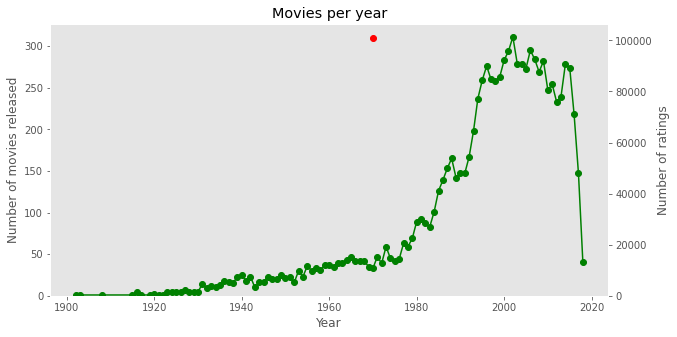

Elapsed time(sec):  0.25


In [16]:
st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['MovieID', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.MovieID.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

dftmp = ratings[['Rating', 'Timestamp']].groupby('Timestamp')
ax2 = ax1.twinx()
ax2.plot(dftmp.Timestamp.first(), dftmp.Rating.count(), "r-o")
ax2.grid(None)
ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

<Figure size 720x360 with 0 Axes>

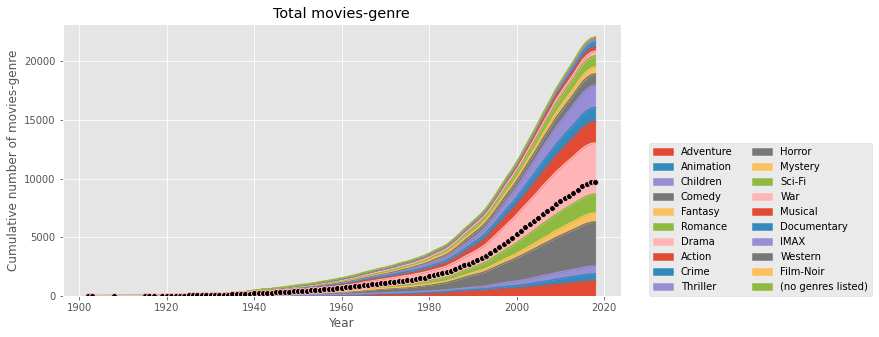

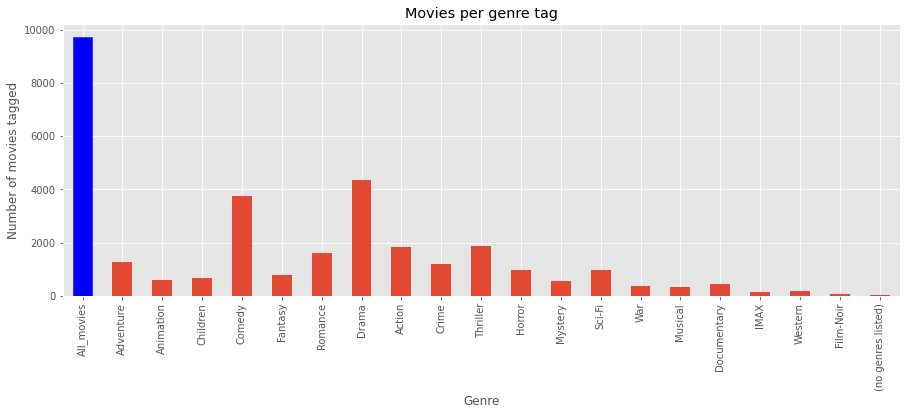

Elapsed time(sec):  0.81


In [18]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['MovieID', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.MovieID.nunique().cumsum()})
# Plot histogram for each individual genre
for Genres in Genres_unique.Genres:
    dftmp = movies[movies[Genres]][['MovieID', 'year']].groupby('year')
    df[Genres]=dftmp.MovieID.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^Genres$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

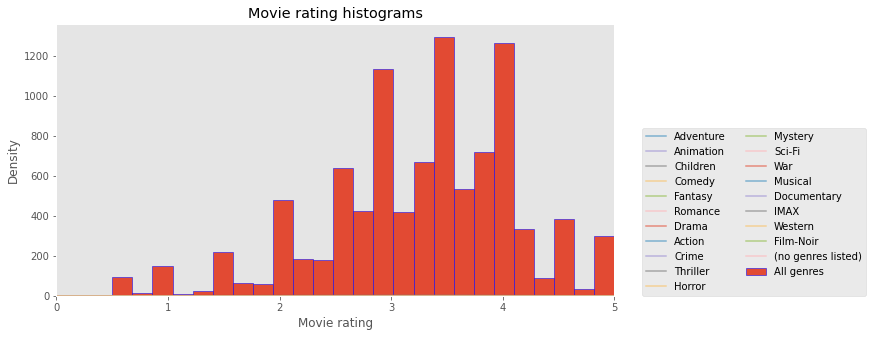

Elapsed time(sec):  1.47


In [25]:
st = default_timer()

dftmp = ratings[['MovieID','Rating']].groupby('MovieID').mean()

# Initialize empty list to capture basic stats by gere
rating_stats = []
# Plot general histogram of all ratings
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='All genres', figsize=(10,5))
# Plot histograms (kde lines for better visibility) per genre
for Genres in Genres_unique.Genres:
    dftmp = movies[movies[Genres]==True]
    dftmp = ratings[ratings.set_index('MovieID').index.isin(dftmp.set_index('MovieID').index)]
    dftmp = dftmp[['MovieID','Rating']].groupby('MovieID').mean()
    dftmp.Rating.plot(grid=False, alpha=0.6, kind='kde', label=Genres)
    avg = dftmp.Rating.mean()
    std = dftmp.Rating.std()
    rating_stats.append((Genres, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histograms')
plt.show()

# Housekeeping
%reset_selective -f (^avg$|^dftmp$|^genre$|^std$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

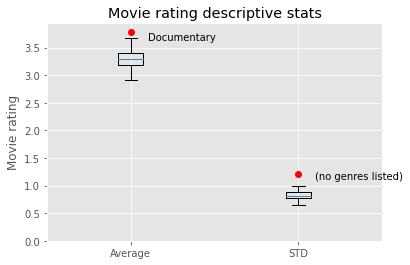

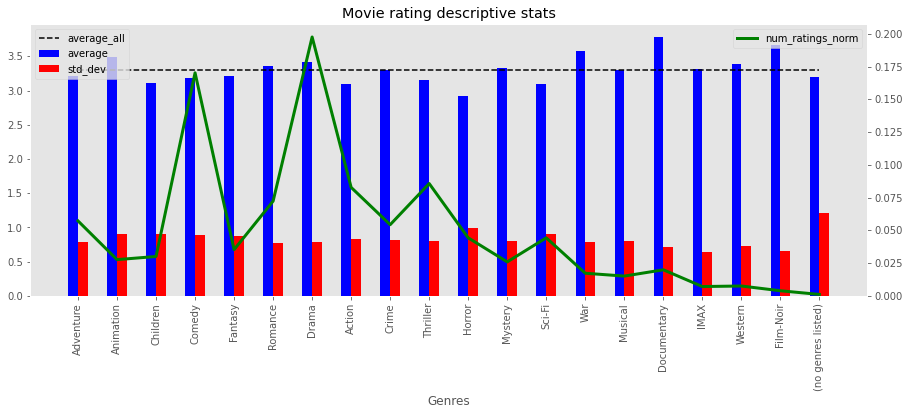

Outliers:  {'(no genres listed)', 'Documentary'}
Genres            Adventure  Animation  Children    Comedy   Fantasy  \
average            3.215230   3.497119  3.107690  3.181716  3.218843   
std_dev            0.792274   0.902377  0.907741  0.883640  0.876802   
num_ratings_norm   0.057232   0.027687  0.030089  0.170201  0.035300   
average_all        3.306550   3.306550  3.306550  3.306550  3.306550   

Genres             Romance     Drama    Action     Crime  Thriller    Horror  \
average           3.364870  3.420639  3.094276  3.301844  3.156017  2.918965   
std_dev           0.771854  0.780908  0.838444  0.819136  0.801195  0.992273   
num_ratings_norm  0.072322  0.197526  0.082790  0.054332  0.085735  0.044318   
average_all       3.306550  3.306550  3.306550  3.306550  3.306550  3.306550   

Genres             Mystery    Sci-Fi       War   Musical  Documentary  \
average           3.330364  3.103103  3.571655  3.296371     3.781682   
std_dev           0.806418  0.898139  0.784

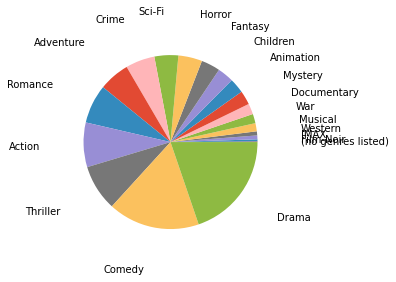

Elapsed time(sec):  0.73


In [26]:
st = default_timer()

# Construct a DataFrame with all the basic stats per genre
rating_sum = pd.DataFrame(rating_stats,  columns=['Genres', 'average', 'std_dev'])
rating_sum.set_index('Genres', inplace=True)
# Display a boxplot to show the dispersion of average and standard deviation
bxplot = plt.boxplot(rating_sum.T, labels=['Average', 'STD'], sym="ro")
# Properly label the outliers
outliers = []
for i, value in enumerate(bxplot['fliers']):
    for val in value.get_ydata():
        bxplot_label = rating_sum.index[rating_sum.iloc[:, i] == val][0]
        outliers.append(bxplot_label)
        plt.annotate(bxplot_label, xy=(i+1.1, val+np.random.uniform(-0.25,0.25))) # Trick to prevent overlapping
outliers = set(outliers)
plt.ylim(0,)
plt.ylabel('Movie rating')
plt.title('Movie rating descriptive stats')
plt.show()

# Bar chart with average rating, standard deviation and normalized number of ratings per genre
# Calculate the normalized number of ratings per genre
rating_sum['num_ratings_norm']=df.iloc[-1, 1:]/df.iloc[-1, 1:].sum()
# Calculate the average rating for all genres
rating_sum['average_all']=rating_sum.average.mean()

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

rating_sum[['average', 'std_dev']].plot(kind='bar', color=['b','r'], ax=ax, position=0.5, grid=False)
rating_sum['average_all'].plot(kind='line',style='--', color=['black'], ax=ax, grid=False)
rating_sum['num_ratings_norm'].plot(kind='line', color='g', ax=ax2, grid=False, linewidth=3)

ax.legend(loc=2)
ax2.legend(loc=1)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Movie rating descriptive stats')
plt.autoscale()
ax2.set_ylim(0,)
plt.show()

print("Outliers: ", outliers)
print(rating_sum.T)

# Quick pie chart to visualize how 3 genres take almost 50% of ratings
rating_sum.sort_values(by='num_ratings_norm', inplace=True)
plt.pie(rating_sum['num_ratings_norm'], labels=rating_sum.T.columns, labeldistance=1.5)
plt.show()


# Housekeeping
%reset_selective -f (^avg$|ax|bxplot|^df$|^dftmp$|^i$|^rating_stats$|^rating_sum$|^val$|^value$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))